In [3]:
import matplotlib.pyplot as plt
from tueplots import bundles
import numpy as np
from adjustText import adjust_text

plt.rcParams.update(bundles.iclr2024())

def plot_ticks(ticks):
    res = []
    for i in ticks:
        i = str(i)
        if '/' in i:
            i = i.split('/')[-1]
        res.append(i)
    return res

compute_fractions = [0, 0.015625]
while compute_fractions[-1] != 1.0:
    compute_fractions.append(compute_fractions[-1] * 2)
proliferation_models = [
                           "Qwen/Qwen2-72B-Instruct",
                           'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo',
                           'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
                           'google/gemma-2-27b-it',
                           'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
                           'google/gemma-2-9b-it',
                       ][::-1]

In [2]:
from rapidresponsebench.utils.data import RESULT
import matplotlib.pyplot as plt


raw_results = RESULT.list()

def all_unique(param):
    return sorted({i.params[param] for i in raw_results})

def fetch_results(results=None, **kwargs):
    if results is None:
        results = raw_results
    res = []
    for i in results:
        if all(item in i.params.items() for item in kwargs.items()):
            res.append(i)
    return res



MODELS = all_unique("model")
PROLIFERATION_MODELS = all_unique("proliferation_model")
PROLIFERATION_COMPUTE_FRACTIONS = all_unique("proliferation_compute_fraction")
RESPONSES = all_unique("response")
SHOTS = all_unique("shots")

print(MODELS)
print(SHOTS)
print(RESPONSES)
print(PROLIFERATION_MODELS)
print(PROLIFERATION_COMPUTE_FRACTIONS)

['gpt-4o-2024-08-06', 'meta-llama/Llama-3-8b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.2']
[0, 1, 5, 25]
['defenseprompt', 'embedding', 'guardfewshot', 'guardfinetuning', 'regex']
['Qwen/Qwen2-72B-Instruct', 'google/gemma-2-27b-it', 'google/gemma-2-9b-it', 'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo', 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo', 'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo']
[0, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]


3
3
3
3
3
3
3
3


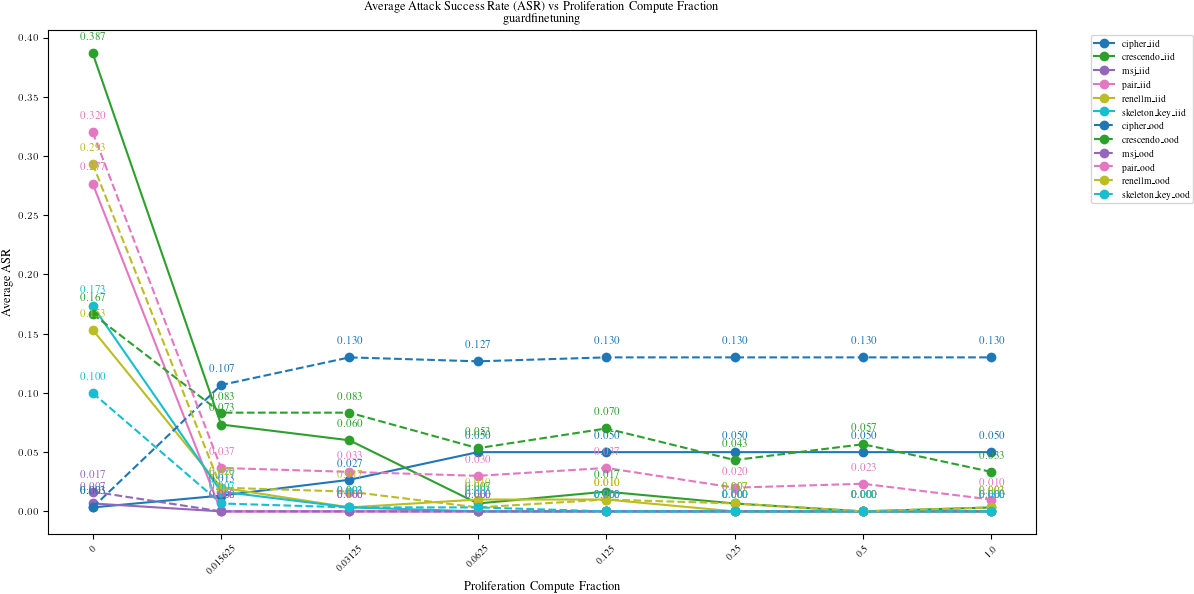

3
3
3
3
3
3
3
3


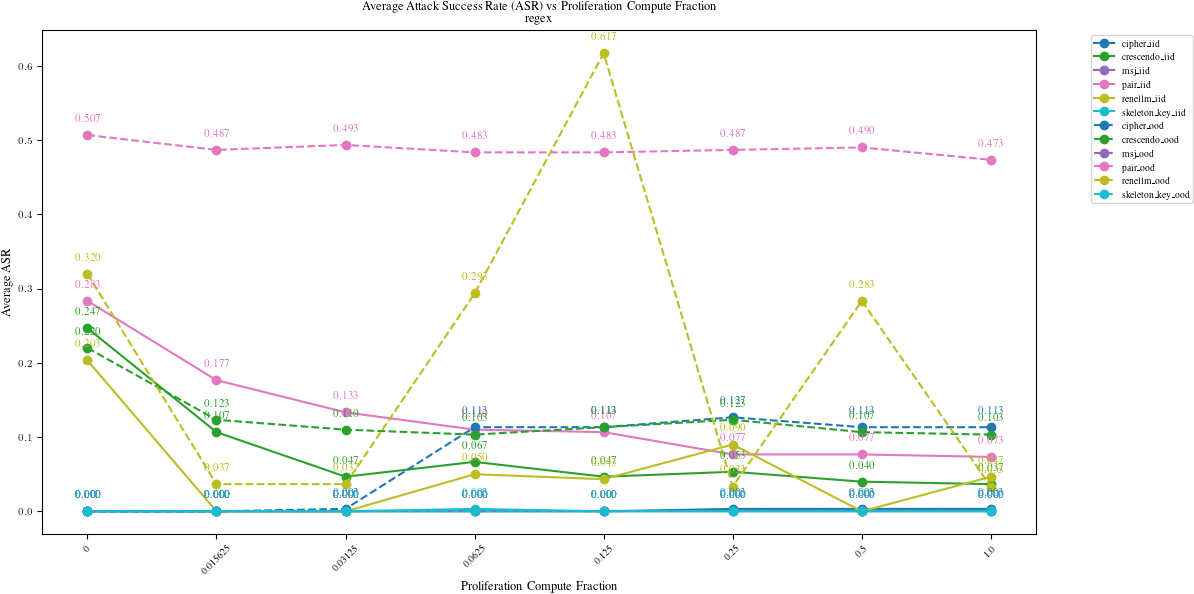

3
3
3
3
3
3
3
3


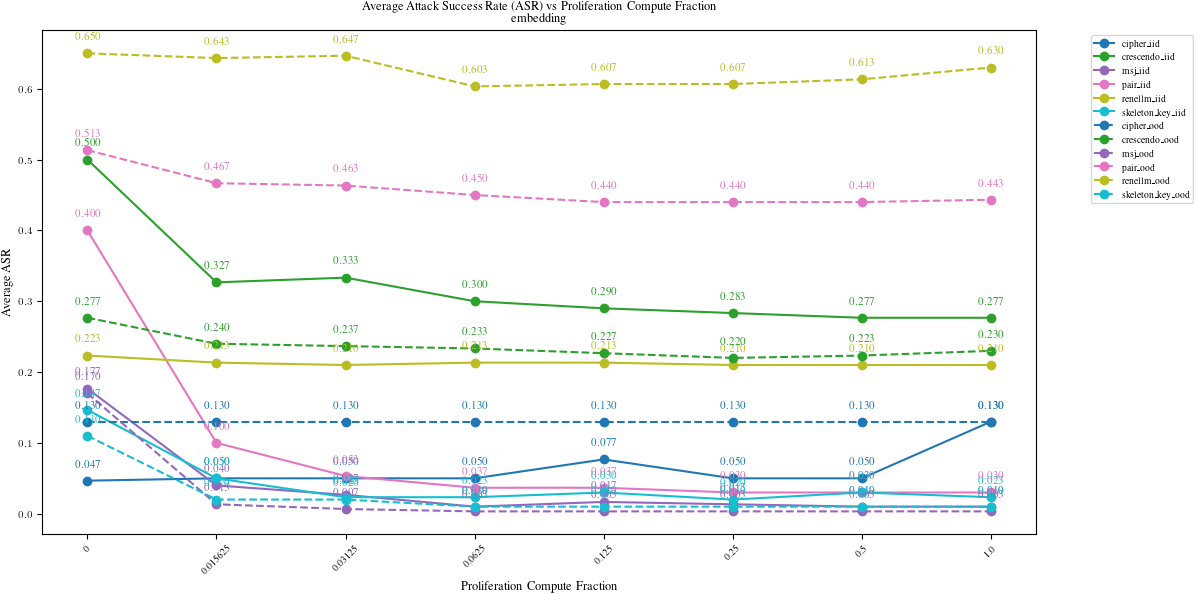

3
3
3
3
3
3
3
3


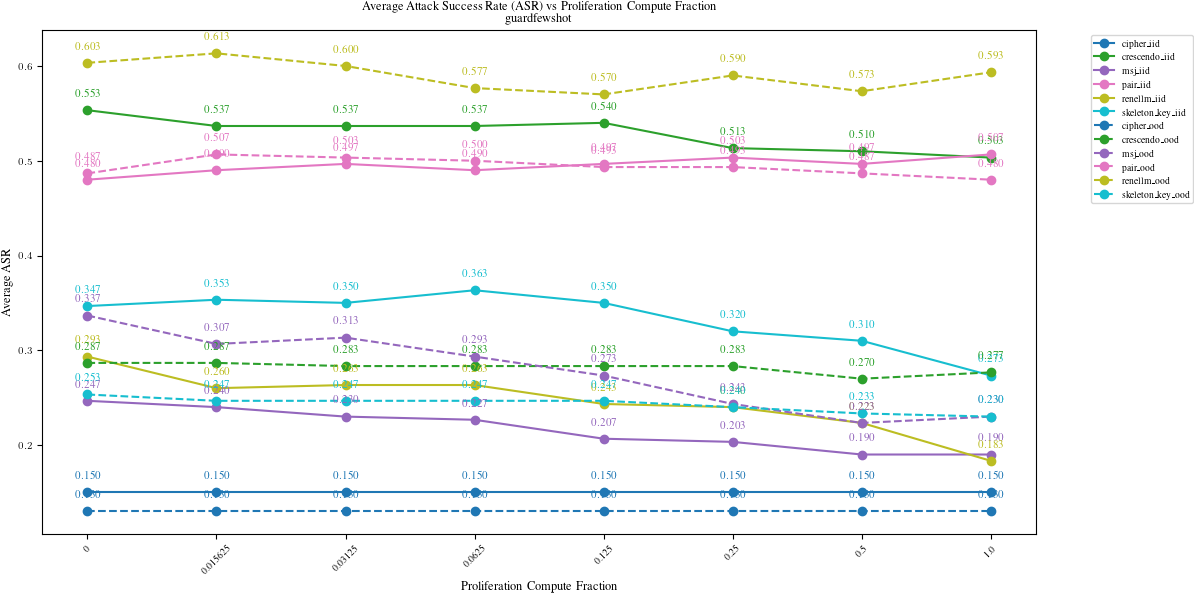

In [27]:


def create_flexible_asr_chart(
    raw_results,
    x_axis_param,
    x_axis_values,
    response,
    model=None,
    proliferation_model=None,
    proliferation_compute_fraction=None,
    proliferation_temperature=None,
    proliferation_top_p=None,
    shots=None,
    annotate=False,
):
    
    # print(response)
    # Filter and extract data from raw_results
    data = []
    for result in raw_results:
        if (result.params['response'] == response and
            (model is None or result.params['model'] == model) and 
            (proliferation_model is None or result.params['proliferation_model'] == proliferation_model) and
            (proliferation_temperature is None or result.params['proliferation_temperature'] == proliferation_temperature) and
            (proliferation_top_p is None or result.params['proliferation_top_p'] == proliferation_top_p) and
            (proliferation_compute_fraction is None or result.params['proliferation_compute_fraction'] == proliferation_compute_fraction) and
            (shots is None or result.params['shots'] == shots) and
            result.params[x_axis_param] in x_axis_values):
            
            data.append({
                'proliferation_model': result.params['proliferation_model'],
                'proliferation_temperature': result.params['proliferation_temperature'],
                'proliferation_top_p': result.params["proliferation_top_p"],
                'proliferation_compute_fraction': result.params['proliferation_compute_fraction'],
                'shots': result.params['shots'],
                x_axis_param: result.params[x_axis_param],
                **{k: v['asr'] for k, v in result.json().items() if k.endswith('_iid') or k.endswith('_ood')
                   # or k.endswith('ood2')
                   }
            })

    # Organize data by x_axis_param
    param_data = {value: [] for value in x_axis_values}
    for item in data:
        param_value = item[x_axis_param]
        param_data[param_value].append(item)

    # Calculate average ASR for each attack type and x_axis_param value
    avg_data = {}
    for param_value, items in param_data.items():
        if items:  # Only calculate if there's data for this param value
            print(len(items))
            # print(items)
            # assert len(items) == 3
            avg_data[param_value] = {
                k: sum(item[k] for item in items) / len(items) 
                for k in items[0] if k not in ['proliferation_model', 'proliferation_compute_fraction', 'proliferation_temperature', 'proliferation_top_p', 'shots', x_axis_param]}

    # Prepare data for plotting
    attack_types = list(next(iter(avg_data.values())).keys()) if avg_data else []

    # Define color scheme and line styles
    colors = plt.cm.tab10(np.linspace(0, 1, len(set(a.split('_')[0] for a in attack_types))))
    color_map = {a.split('_')[0]: c for a, c in zip(sorted(set(a.split('_')[0] for a in attack_types)), colors)}
    
    def get_line_style(attack):
        if attack.endswith('_iid'):
            return '-'
        elif attack.endswith('ood2'):
            return ':'
        else:  # for 'ood'
            return '--'

    # Create the plot
    plt.figure(figsize=(12, 6))
    for attack in attack_types:
        attack_base = attack.split('_')[0]
        color = color_map[attack_base]
        line_style = get_line_style(attack)
        
        y = [avg_data.get(x, {}).get(attack, np.nan) for x in x_axis_values]
        plt.plot(range(len(x_axis_values)), y, color=color, linestyle=line_style, marker='o', label=attack)

        if annotate:
            for i, (x, y_val) in enumerate(zip(range(len(x_axis_values)), y)):
                if not np.isnan(y_val):
                    plt.annotate(f'{y_val:.3f}', (x, y_val), textcoords="offset points", 
                                 xytext=(0,10), ha='center', fontsize=8, color=color)


    plt.xlabel(x_axis_param.replace('_', ' ').title())
    plt.ylabel('Average ASR')
    plt.title(f'Average Attack Success Rate (ASR) vs {x_axis_param.replace("_", " ").title()}\n{response}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(len(x_axis_values)), plot_ticks(x_axis_values), rotation=45)
    # plt.tight_layout()
    # plt.grid(True)

    # Show the plot
    plt.show()

# Example usage:
# for response in 'guardfinetuning', 'embedding', 'regex', 'defenseprompt', 'guardfewshot':
#     create_flexible_asr_chart(
#         raw_results,
#         x_axis_param='shots',
#         x_axis_values=[0, 1, 5, 25],
#         response=response,
#         proliferation_model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
#         proliferation_compute_fraction=1.0,
#         proliferation_temperature=1.0,
#         proliferation_top_p=1.0,
#         annotate=True
#     )




# for response in 'guardfinetuning', 'embedding', 'regex', 'guardfewshot':
#     create_flexible_asr_chart(
#         raw_results,
#         x_axis_param='proliferation_compute_fraction',
#         x_axis_values=compute_fractions,
#         response=response,
#         # model="gpt-4o-2024-08-06",
#         proliferation_model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
#         shots=25
#     )

for response in ['guardfinetuning', 'regex', 'embedding', 'guardfewshot']:
    create_flexible_asr_chart(
        raw_results,
        x_axis_param='proliferation_compute_fraction',
        x_axis_values=compute_fractions,
        response=response,
        proliferation_model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
        # model="gpt-4o-2024-08-06",
        # model="mistralai/Mistral-7B-Instruct-v0.2", 
        # model="meta-llama/Llama-3-8b-chat-hf",
        proliferation_temperature=1.0,
        proliferation_top_p=1.0,
        shots=1,
        annotate=True
    )

# for response in ['guardfinetuning', 'regex', 'embedding', 'guardfewshot']:
#     create_flexible_asr_chart(
#         raw_results,
#         x_axis_param='proliferation_model',
#         x_axis_values=proliferation_models,
#         response=response,
#         # model="gpt-4o-2024-08-06",
#         # model="mistralai/Mistral-7B-Instruct-v0.2",
#         # model="meta-llama/Llama-3-8b-chat-hf",
#         proliferation_compute_fraction=1.0,
#         proliferation_temperature=1.0,
#         proliferation_top_p=1.0,
#         shots=1,
#         annotate=True
#     )




count results 12


/tmp/ipykernel_322860/46139408.py:272: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


saving to shots


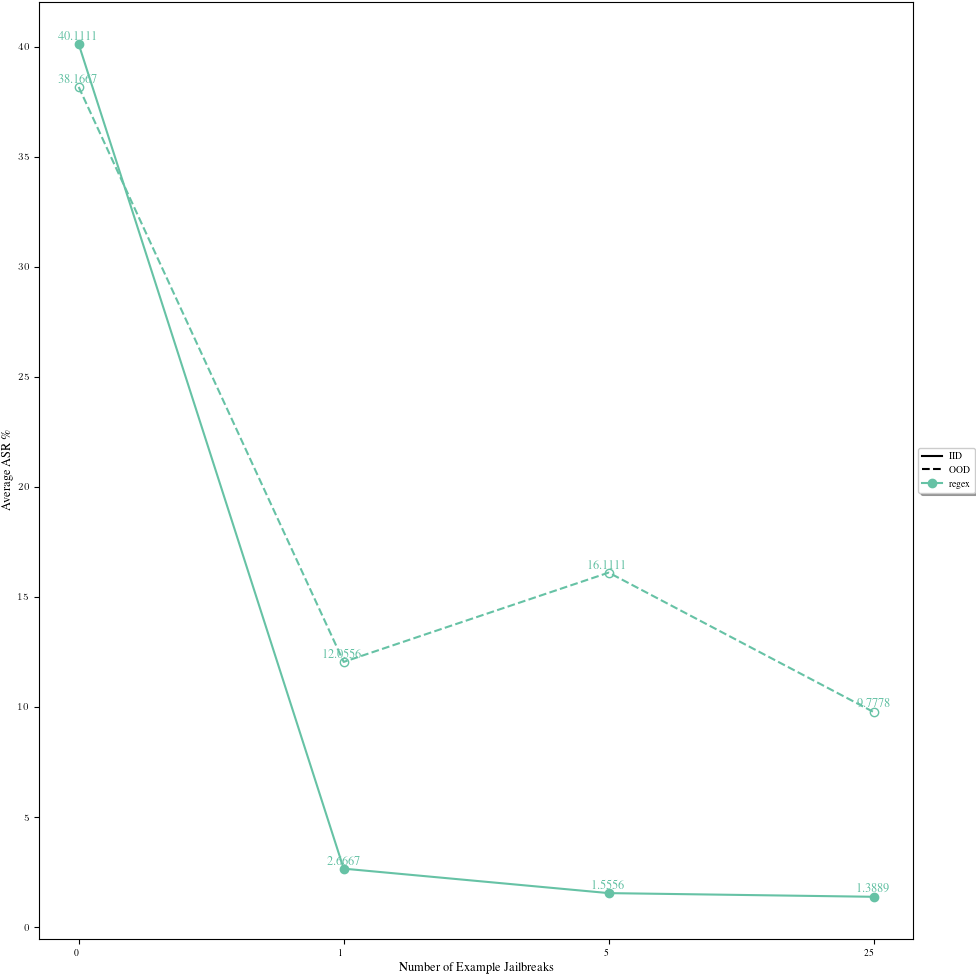

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# def create_asr_chart_multiple_responses(
#         raw_results,
#         x_axis_param,
#         x_axis_values,
#         responses,
#         filter_attacks=None,
#         model=None,
#         proliferation_model=None,
#         proliferation_compute_fraction=None,
#         proliferation_temperature=None,
#         proliferation_top_p=None,
#         shots=None,
#         annotate=False
# ):
#     # Filter and extract data from raw_results
#     data = []
#     for result in raw_results:
#         if (result.params['response'] in responses and
#                 (model is None or result.params['model'] == model) and
#                 (proliferation_temperature is None or result.params['proliferation_temperature'] == proliferation_temperature) and
#                 (proliferation_top_p is None or result.params['proliferation_top_p'] == proliferation_top_p) and
#                 (proliferation_model is None or result.params['proliferation_model'] == proliferation_model) and
#                 (proliferation_compute_fraction is None or result.params['proliferation_compute_fraction'] == proliferation_compute_fraction) and
#                 (shots is None or result.params['shots'] == shots) and
#                 result.params[x_axis_param] in x_axis_values):
#
#             rj = result.json()
#
#             if filter_attacks is not None:
#                 if len(filter_attacks[0]) == 1 or isinstance(filter_attacks[0], str):
#                     rj = {k: v for k, v in rj.items() if not any(i in k for i in filter_attacks)}
#                 else:
#                     rj = {k: v for k, v in rj.items() if not any(i in k and result.params['model'] == m for i, m in filter_attacks)}
#
#
#             data.append({
#                 'response': result.params['response'],
#                 'proliferation_model': result.params['proliferation_model'],
#                 'proliferation_compute_fraction': result.params['proliferation_compute_fraction'],
#                 'shots': result.params['shots'],
#                 x_axis_param: result.params[x_axis_param],
#                 'iid': {k: v['asr'] for k, v in rj.items() if k.endswith('_iid')},
#                 'ood': {k: v['asr'] for k, v in rj.items() if k.endswith('_ood')
#                         # or k.endswith('ood2')
#                         }
#             })
#     print("count results", len(data))
#
#     # Organize data by response and x_axis_param
#     organized_data = {response: {value: [] for value in x_axis_values} for response in responses}
#     for item in data:
#         organized_data[item['response']][item[x_axis_param]].append(item)
#
#     # Calculate average ASR for IID and OOD attacks
#     avg_data = {response: {} for response in responses}
#     for response in responses:
#         for param_value, items in organized_data[response].items():
#             print(len(items))
#             if len(items) == 1:
#                 print(response, param_value, items)
#             if items:
#                 avg_data[response][param_value] = {
#                     'iid': sum(sum(item['iid'].values()) / len(item['iid']) for item in items) / len(items),
#                     'ood': sum(sum(item['ood'].values()) / len(item['ood']) for item in items) / len(items)
#                 }
#
#     # Create the plot
#     plt.figure(figsize=(12, 6))
#     print(x_axis_values)
#     colors = plt.cm.tab10(np.linspace(0, 1, len(responses)))
#
#
#     linthresh = float('inf')
#     annotations = []
#     for i, response in enumerate(responses):
#         color = colors[i]
#
#         # Plot IID line
#         iid_y = [avg_data[response].get(x, {}).get('iid', np.nan) for x in x_axis_values]
#         plt.plot(range(len(x_axis_values)), iid_y, color=color, linestyle='-', marker='o', label=f'{response} IID')
#
#         # Plot OOD line
#         ood_y = [avg_data[response].get(x, {}).get('ood', np.nan) for x in x_axis_values]
#         plt.plot(range(len(x_axis_values)), ood_y, color=color, linestyle='--', marker='s', label=f'{response} OOD')
#
#         for j in iid_y + ood_y:
#             if j > 0:
#                 linthresh = min(linthresh, j)
#
#         # Add annotations
#         if annotate:
#             for j, (iid_val, ood_val) in enumerate(zip(iid_y, ood_y)):
#                 if not np.isnan(iid_val):
#                     annotations.append(plt.annotate(f'{iid_val:.4f}', (j, iid_val), textcoords="offset points", xytext=(0,3), ha='center', color=color))
#                 if not np.isnan(ood_val):
#                     annotations.append(plt.annotate(f'{ood_val:.4f}', (j, ood_val), textcoords="offset points", xytext=(0,3), ha='center', color=color))
#
#
#     plt.xlabel(x_axis_param.replace('_', ' ').title())
#     plt.ylabel('Average ASR')
#
#     title = f'Average ASR vs {x_axis_param.replace("_", " ").title()}'
#     if model:
#         title += f" ({model})"
#     plt.title(title)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#
#
#     plt.yscale('symlog', linthresh=linthresh, linscale=0.2)
#
#     if x_axis_param == "proliferation_model":
#         mp = {
#             'Meta-Llama-3.1-405B-Instruct-Turbo,Meta-Llama-3.1-70B-Instruct-Turbo': '405b,70b',
#             'Meta-Llama-3.1-405B-Instruct-Turbo,Meta-Llama-3.1-70B-Instruct-Turbo,gemma-2-27b-it': '405b,70b,27b',
#             'Meta-Llama-3.1-405B-Instruct-Turbo,Meta-Llama-3.1-70B-Instruct-Turbo,gemma-2-27b-it,Meta-Llama-3.1-8B-Instruct-Turbo': '405b,70b,27b,8b',
#             'Meta-Llama-3.1-405B-Instruct-Turbo,Meta-Llama-3.1-70B-Instruct-Turbo,gemma-2-27b-it,Meta-Llama-3.1-8B-Instruct-Turbo,gemma-2-9b-it': '405b,70b,27b,8b,9b'
#         }
#         x_axis_values = [mp.get(i, i) for i in x_axis_values]
#
#     plt.xticks(range(len(x_axis_values)), plot_ticks(x_axis_values), rotation=45)
#     plt.tight_layout()
#     plt.grid(True)
#
#     # if annotations:
#     #     adjust_text(annotations)
#
#     # Show the plot
#     # plt.show()

def create_asr_chart_multiple_responses(
        raw_results,
        x_axis_param,
        x_axis_values,
        responses,
        filter_attacks=None,
        model=None,
        proliferation_model=None,
        proliferation_compute_fraction=None,
        proliferation_temperature=1.0,
        proliferation_top_p=1.0,
        shots=None,
        log=True,
        annotate=False
):
    # Filter and extract data from raw_results
    data = []
    for result in raw_results:
        if (result.params['response'] in responses and
                (model is None or result.params['model'] == model) and
                (proliferation_temperature is None or result.params['proliferation_temperature'] == proliferation_temperature) and
                (proliferation_top_p is None or result.params['proliferation_top_p'] == proliferation_top_p) and
                (proliferation_model is None or result.params['proliferation_model'] == proliferation_model) and
                (proliferation_compute_fraction is None or result.params['proliferation_compute_fraction'] == proliferation_compute_fraction) and
                (shots is None or result.params['shots'] == shots) and
                result.params[x_axis_param] in x_axis_values):

            rj = result.json()

            if filter_attacks is not None:
                if len(filter_attacks[0]) == 1 or isinstance(filter_attacks[0], str):
                    rj = {k: v for k, v in rj.items() if not any(i in k for i in filter_attacks)}
                else:
                    rj = {k: v for k, v in rj.items() if not any(i in k and result.params['model'] == m for i, m in filter_attacks)}

            data.append({
                'response': result.params['response'],
                'proliferation_model': result.params['proliferation_model'],
                'proliferation_compute_fraction': result.params['proliferation_compute_fraction'],
                'shots': result.params['shots'],
                x_axis_param: result.params[x_axis_param],
                'iid': {k: v['asr'] for k, v in rj.items() if k.endswith('_iid')},
                'ood': {k: v['asr'] for k, v in rj.items() if k.endswith('_ood')}
            })
    print("count results", len(data))

    # Organize data by response and x_axis_param
    organized_data = {response: {value: [] for value in x_axis_values} for response in responses}
    for item in data:
        organized_data[item['response']][item[x_axis_param]].append(item)

    # Calculate average ASR for IID and OOD attacks
    avg_data = {response: {} for response in responses}
    for response in responses:
        for param_value, items in organized_data[response].items():
            if items:
                avg_data[response][param_value] = {
                    'iid': sum(sum(item['iid'].values()) / len(item['iid']) for item in items) / len(items),
                    'ood': sum(sum(item['ood'].values()) / len(item['ood']) for item in items) / len(items)
                }

    # Apply tueplots style
    fig, ax = plt.subplots(figsize=(10, 10))

    # Use a colorblind-friendly palette
    colors = plt.cm.Set2(np.linspace(0, 1, len(responses)))

    linthresh = float('inf')
    annotations = []
    markers = ['o', 's', '^', 'D', 'v']
    linestyles = ['-', '--']

    for i, response in enumerate(responses):
        color = colors[i]
        marker = markers[i % len(markers)]

        # Plot IID line
        iid_y = [avg_data[response].get(x, {}).get('iid', np.nan) * 100 for x in x_axis_values]
        ood_y = [avg_data[response].get(x, {}).get('ood', np.nan) * 100 for x in x_axis_values]

        # if log:
        #     for l in [iid_y, ood_y]:
        #         for j in range(len(l)):
        #             l[j] += 1/ 1800

        ax.plot(range(len(x_axis_values)), iid_y, color=color, linestyle=linestyles[0], marker=marker,
                markersize=6, linewidth=1.5, label=f'{response}')
        ax.plot(range(len(x_axis_values)), ood_y, color=color, linestyle=linestyles[1], marker=marker,
                markersize=6, linewidth=1.5, markerfacecolor='none')

        for j in iid_y + ood_y:
            if j > 0:
                linthresh = min(linthresh, j * 1.2)

        # Add annotations
        if annotate:
            for j, (iid_val, ood_val) in enumerate(zip(iid_y, ood_y)):
                if not np.isnan(iid_val):
                    annotations.append(ax.annotate(f'{iid_val:.4f}', (j, iid_val), textcoords="offset points", xytext=(0,3), ha='center', color=color))
                if not np.isnan(ood_val):
                    annotations.append(ax.annotate(f'{ood_val:.4f}', (j, ood_val), textcoords="offset points", xytext=(0,3), ha='center', color=color))


    if x_axis_param == "shots":
        x_label = "Number of Example Jailbreaks"
    else:
        x_label = x_axis_param.replace('_', ' ').title()

    ax.set_xlabel(x_label)
    ax.set_ylabel('Average ASR \%')



    # title = f'Average ASR vs {x_axis_param.replace("_", " ").title()}'
    # if model:
    #     title += f" ({model})"
    # ax.set_title(title)

    # Create a custom legend
    legend_elements = [plt.Line2D([0], [0], color='k', linestyle='-', label='IID'),
                       plt.Line2D([0], [0], color='k', linestyle='--', label='OOD')]
    for i, response in enumerate(responses):
        legend_elements.append(plt.Line2D([0], [0], color=colors[i], marker=markers[i % len(markers)],
                                          linestyle='-', label=response))

    # Place legend outside the plot area
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
              frameon=True, fancybox=True, shadow=True)

    ax.set_xticks(range(len(x_axis_values)))
    rotation = 45 if "model" in x_axis_param else 0
    ax.set_xticklabels(plot_ticks(x_axis_values), rotation=rotation, ha='right')
    if log:
        ax.set_yscale(
            'log',
            # linthresh=linthresh,
            # linscale=0.2
        )
    # Adjust layout and display
    fig.tight_layout()
    print("saving to", x_axis_param)
    # fig.savefig(f"plots/{x_axis_param}.png",  bbox_inches='tight', dpi=300)
    # fig.show()
    # plt.close(fig)


# Example usage:
create_asr_chart_multiple_responses(
    raw_results,
    x_axis_param='shots',
    x_axis_values=[0, 1, 5, 25],
    responses=['regex'],
    # model="gpt-4o-2024-08-06",
    proliferation_model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    proliferation_compute_fraction=1.0,
    annotate=True,
    log=False,
)
#



count results 120
saving to proliferation_compute_fraction


/tmp/ipykernel_4056567/4175875520.py:264: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


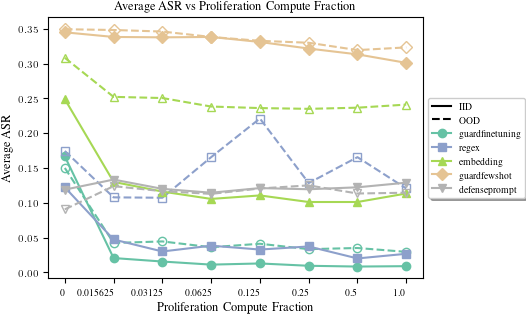

In [20]:
create_asr_chart_multiple_responses(
    raw_results,
    x_axis_param='proliferation_compute_fraction',
    x_axis_values=compute_fractions,
    responses=['guardfinetuning', 'regex', 'embedding', 'guardfewshot', 'defenseprompt'],
    # model="gpt-4o-2024-08-06",
    # model="mistralai/Mistral-7B-Instruct-v0.2",

    proliferation_model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    annotate=True,
    shots=1
)

In [36]:
MODELS

['gpt-4o-2024-08-06',
 'meta-llama/Llama-3-8b-chat-hf',
 'mistralai/Mistral-7B-Instruct-v0.2']

count results 90


/tmp/ipykernel_322860/2736090421.py:272: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


saving to proliferation_model


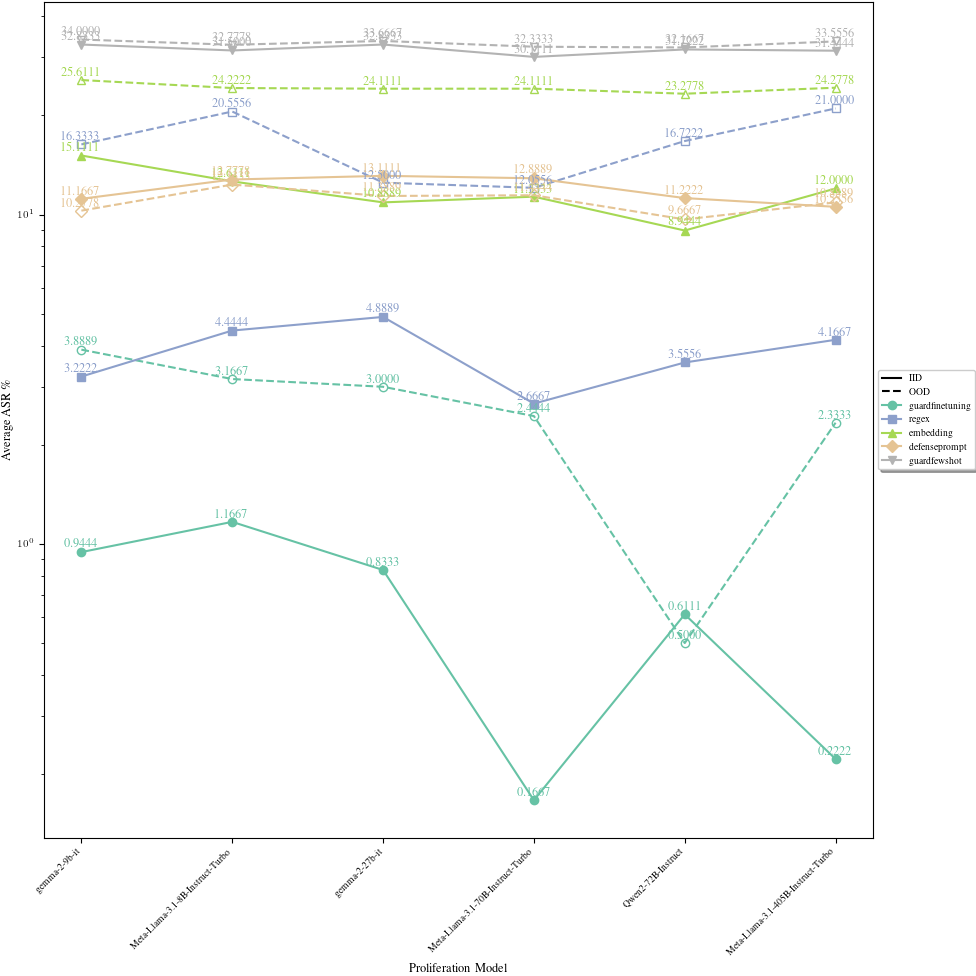

In [5]:

proliferation_models = [
    'google/gemma-2-9b-it',
    'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
    'google/gemma-2-27b-it',
    'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    "Qwen/Qwen2-72B-Instruct",
    'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo',
]

create_asr_chart_multiple_responses(
    raw_results,
    x_axis_param='proliferation_model',
    x_axis_values=proliferation_models,
    responses=['guardfinetuning', 'regex', 'embedding', 'defenseprompt', 'guardfewshot'],
    proliferation_compute_fraction=1.0,
    shots=1,
    annotate=True,
)

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def create_easy_refusal_rate_chart(
    raw_results,
    x_axis_param,
    x_axis_values,
    responses,
    model=None,
    proliferation_model=None,
    proliferation_compute_fraction=None,
    proliferation_temperature=None,
    proliferation_top_p=None,
    shots=None,
    annotate=False
):
    # Filter and extract data from raw_results
    data = []
    for result in raw_results:
        if (result.params['response'] in responses and
            (model is None or result.params['model'] == model) and 
            (proliferation_model is None or result.params['proliferation_model'] == proliferation_model) and
            (proliferation_compute_fraction is None or result.params['proliferation_compute_fraction'] == proliferation_compute_fraction) and
            (proliferation_temperature is None or result.params['proliferation_temperature'] == proliferation_temperature) and
            (proliferation_top_p is None or result.params['proliferation_top_p'] == proliferation_top_p) and
            (shots is None or result.params['shots'] == shots) and
            result.params[x_axis_param] in x_axis_values):

            data.append({
                'response': result.params['response'],
                'model': result.params['model'],
                'proliferation_model': result.params['proliferation_model'],
                'proliferation_compute_fraction': result.params['proliferation_compute_fraction'],
                'shots': result.params['shots'],
                x_axis_param: result.params[x_axis_param],
                'easy_refusal_rate': result.json()['easy_refusal_rate']
            })

    # Organize data by response and x_axis_param
    organized_data = {response: {value: [] for value in x_axis_values} for response in responses}
    for item in data:
        organized_data[item['response']][item[x_axis_param]].append(item)

    # Calculate average easy_refusal_rate
    avg_data = {response: {} for response in responses}
    for response in responses:
        for param_value, items in organized_data[response].items():
            if items:
                avg_data[response][param_value] = sum(item['easy_refusal_rate'] for item in items) / len(items)

    # Create the plot
    plt.figure(figsize=(12, 6))

    colors = plt.cm.tab10(np.linspace(0, 1, len(responses)))
    for i, response in enumerate(responses):
        color = colors[i]

        # Plot easy_refusal_rate line
        y_values = [avg_data[response].get(x, np.nan) for x in x_axis_values]
        plt.plot(range(len(x_axis_values)), y_values, color=color, linestyle='-', marker='o', label=f'{response}')

        # Add annotations
        if annotate:
            for j, val in enumerate(y_values):
                if not np.isnan(val):
                    plt.annotate(f'{val:.3f}', (j, val), textcoords="offset points", xytext=(0,3), ha='center')

    plt.xlabel(x_axis_param.replace('_', ' ').title())
    plt.ylabel('Average Easy Refusal Rate')

    title = f'Average Easy Refusal Rate vs {x_axis_param.replace("_", " ").title()}'
    if model:
        title += f" ({model})"

    plt.title(title)
    plt.legend(loc='best')
    plt.xticks(range(len(x_axis_values)), plot_ticks(x_axis_values), rotation=45)
    plt.tight_layout()
    plt.grid(True)

    # Show the plot
    plt.show()

def create_easy_refusal_rate_chart(
        raw_results,
        x_axis_param,
        x_axis_values,
        responses,
        model=None,
        proliferation_model=None,
        proliferation_compute_fraction=None,
        proliferation_temperature=1.0,
        proliferation_top_p=1.0,
        shots=None,
        log=False,
        annotate=False
):
    # Filter and extract data from raw_results
    data = []
    for result in raw_results:
        if (result.params['response'] in responses and
                (model is None or result.params['model'] == model) and
                (proliferation_model is None or result.params['proliferation_model'] == proliferation_model) and
                (proliferation_compute_fraction is None or result.params['proliferation_compute_fraction'] == proliferation_compute_fraction) and
                (proliferation_temperature is None or result.params['proliferation_temperature'] == proliferation_temperature) and
                (proliferation_top_p is None or result.params['proliferation_top_p'] == proliferation_top_p) and
                (shots is None or result.params['shots'] == shots) and
                result.params[x_axis_param] in x_axis_values):

            data.append({
                'response': result.params['response'],
                'model': result.params['model'],
                'proliferation_model': result.params['proliferation_model'],
                'proliferation_compute_fraction': result.params['proliferation_compute_fraction'],
                'shots': result.params['shots'],
                x_axis_param: result.params[x_axis_param],
                'easy_refusal_rate': result.json()['easy_refusal_rate']
            })

    # Organize data by response and x_axis_param
    organized_data = {response: {value: [] for value in x_axis_values} for response in responses}
    for item in data:
        organized_data[item['response']][item[x_axis_param]].append(item)

    # Calculate average easy_refusal_rate
    avg_data = {response: {} for response in responses}
    for response in responses:
        for param_value, items in organized_data[response].items():
            if items:
                avg_data[response][param_value] = sum(item['easy_refusal_rate'] for item in items) / len(items)

    # Apply tueplots style
    fig, ax = plt.subplots()

    # Use a colorblind-friendly palette
    colors = plt.cm.Set2(np.linspace(0, 1, len(responses)))

    markers = ['o', 's', '^', 'D', 'v']
    annotations = []

    for i, response in enumerate(responses):
        color = colors[i]
        marker = markers[i % len(markers)]

        # Plot easy_refusal_rate line
        y_values = [avg_data[response].get(x, np.nan) for x in x_axis_values]

        if log:
            y_values = [y + 1/1800 if y > 0 else y for y in y_values]

        ax.plot(range(len(x_axis_values)), y_values, color=color, linestyle='-', marker=marker,
                markersize=6, linewidth=1.5, label=f'{response}')

        # Add annotations
        if annotate:
            for j, val in enumerate(y_values):
                if not np.isnan(val):
                    annotations.append(ax.annotate(f'{val:.4f}', (j, val), textcoords="offset points", xytext=(0,3), ha='center', color=color))

    if x_axis_param == "shots":
        x_label = "Number of Example Jailbreaks"
    else:
        x_label = x_axis_param.replace('_', ' ').title()

    ax.set_xlabel(x_label)
    ax.set_ylabel('Average Refusal Rate')

    title = f'Average Refusal Rate vs {x_axis_param.replace("_", " ").title()}'
    if model:
        title += f" ({model})"
    ax.set_title(title)

    # Place legend outside the plot area
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              frameon=True, fancybox=True, shadow=True)

    ax.set_xticks(range(len(x_axis_values)))
    rotation = 45 if "model" in x_axis_param else 0
    ax.set_xticklabels(plot_ticks(x_axis_values), rotation=rotation, ha='right')

    if log:
        ax.set_yscale('log')

    # Adjust layout and display
    # fig.show()
    fig.tight_layout()
    fig.savefig(f"plots/easy_refusal_rate_{x_axis_param}.png", bbox_inches='tight', dpi=300)
    plt.close(fig)

# Example usage:
create_easy_refusal_rate_chart(
    raw_results,
    x_axis_param='shots',
    x_axis_values=[0, 1, 5, 25],
    responses=['guardfinetuning', 'regex', 'embedding', 'defenseprompt', 'guardfewshot'],
    proliferation_model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    proliferation_compute_fraction=1.0,
    # annotate=True
)

create_easy_refusal_rate_chart(
    raw_results,
    x_axis_param='proliferation_compute_fraction',
    x_axis_values=compute_fractions,
    responses=['guardfinetuning', 'regex', 'embedding', 'defenseprompt', 'guardfewshot'],
    # model="gpt-4o-2024-08-06",
    proliferation_model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    shots=1,
    # annotate=True

)

create_easy_refusal_rate_chart(
    raw_results,
    x_axis_param='proliferation_model',
    x_axis_values=proliferation_models,
    responses=['guardfinetuning', 'regex', 'embedding', 'defenseprompt', 'guardfewshot'],
    proliferation_compute_fraction=1.0,
    shots=1,
    # annotate=True
)

/tmp/ipykernel_4056567/1916665150.py:186: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_4056567/1916665150.py:186: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_4056567/1916665150.py:186: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [ ]:
!apt install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng


In [ ]:
!pip install latex

/tmp/ipykernel_4056567/2355573398.py:264: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_4056567/2355573398.py:264: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_4056567/2355573398.py:264: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


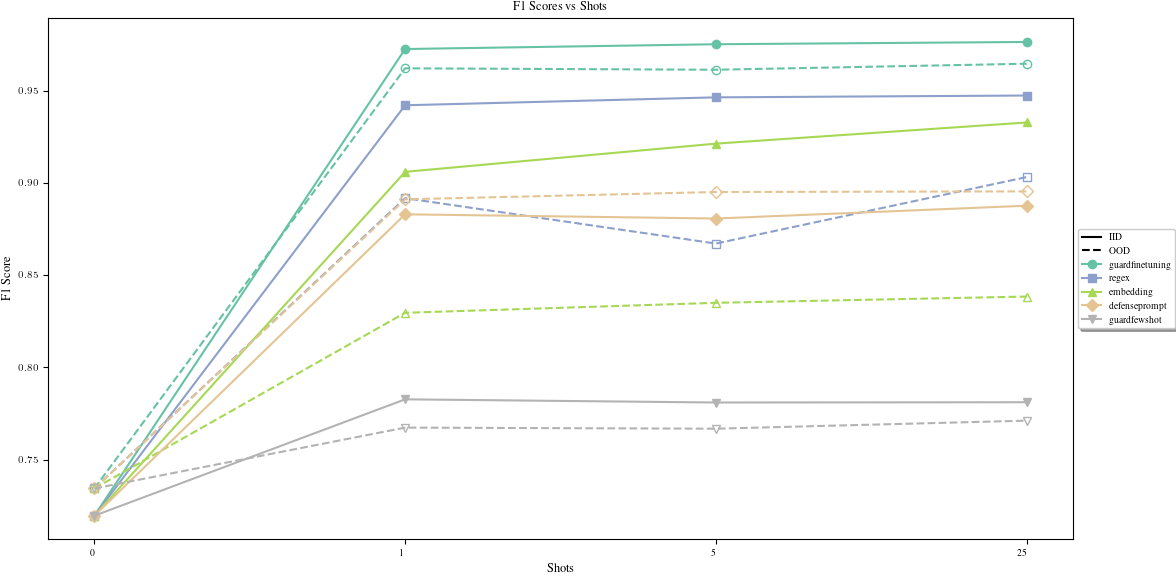

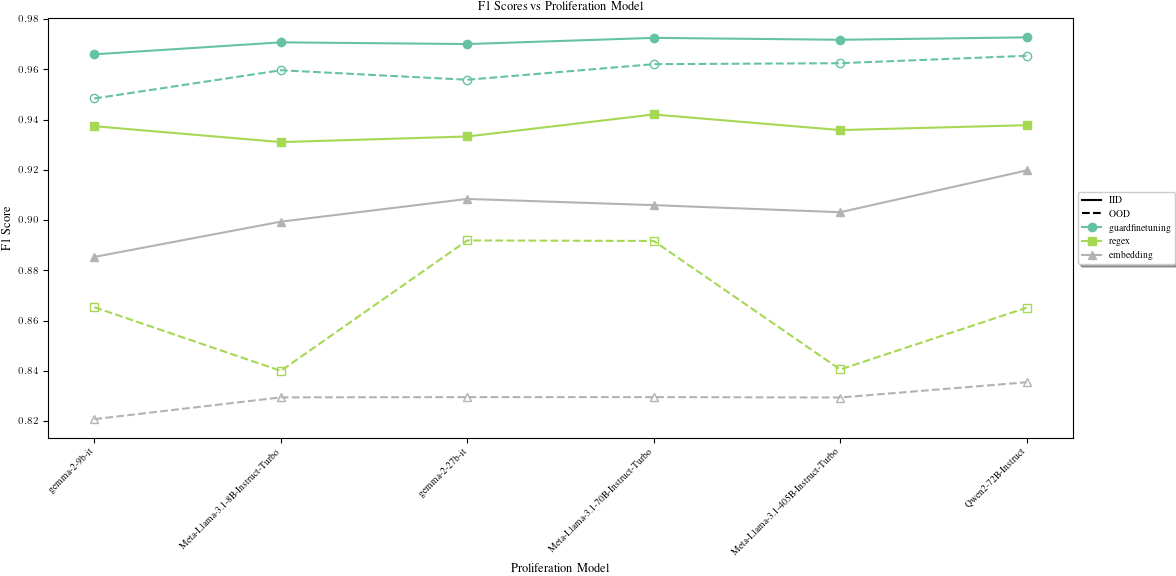

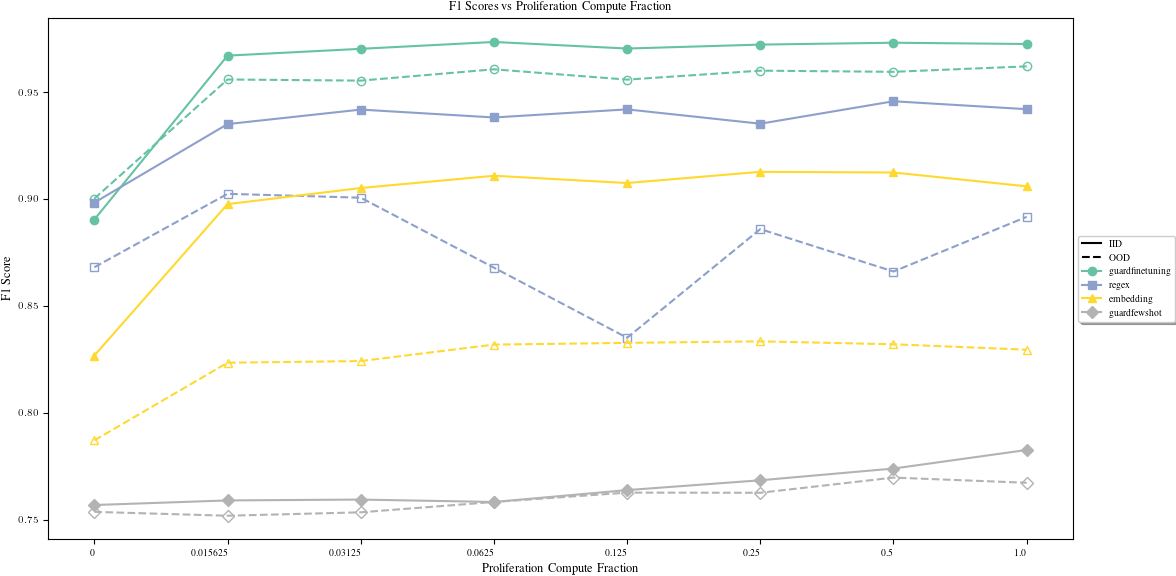

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def create_f1_score_chart(
        raw_results,
        x_axis_param,
        x_axis_values,
        responses,
        filter_attacks=None,
        model=None,
        proliferation_model=None,
        proliferation_compute_fraction=None,
        proliferation_temperature=None,
        proliferation_top_p=None,
        shots=None,
        annotate=False,
        N_JAILBREAKS=600,
        N_BENIGN_QUERIES=600
):
    # Filter and extract data from raw_results
    data = []
    for result in raw_results:
        if (result.params['response'] in responses and
                (model is None or result.params['model'] == model) and
                (proliferation_temperature is None or result.params['proliferation_temperature'] == proliferation_temperature) and
                (proliferation_top_p is None or result.params['proliferation_top_p'] == proliferation_top_p) and
                (proliferation_model is None or result.params['proliferation_model'] == proliferation_model) and
                (proliferation_compute_fraction is None or result.params['proliferation_compute_fraction'] == proliferation_compute_fraction) and
                (shots is None or result.params['shots'] == shots) and
                result.params[x_axis_param] in x_axis_values):

            rj = result.json()

            if filter_attacks is not None:
                if len(filter_attacks[0]) == 1 or isinstance(filter_attacks[0], str):
                    rj = {k: v for k, v in rj.items() if not any(i in k for i in filter_attacks)}
                else:
                    rj = {k: v for k, v in rj.items() if not any(i in k and result.params['model'] == m for i, m in filter_attacks)}

            data.append({
                'response': result.params['response'],
                'proliferation_model': result.params['proliferation_model'],
                'proliferation_compute_fraction': result.params['proliferation_compute_fraction'],
                'shots': result.params['shots'],
                x_axis_param: result.params[x_axis_param],
                'iid': {k: v['asr'] for k, v in rj.items() if k.endswith('_iid')},
                'ood': {k: v['asr'] for k, v in rj.items() if k.endswith('_ood')},
                'easy_refusal_rate': rj['easy_refusal_rate']
            })

    # Organize data by response and x_axis_param
    organized_data = {response: {value: [] for value in x_axis_values} for response in responses}
    for item in data:
        organized_data[item['response']][item[x_axis_param]].append(item)

    # Calculate F1 score
    def calculate_f1(precision, recall):
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    def calculate_precision(asr, easy_refusal_rate):
        return ((1 - asr) * N_JAILBREAKS) / (easy_refusal_rate * N_BENIGN_QUERIES + (1 - asr) * N_JAILBREAKS)

    avg_data = {response: {} for response in responses}
    for response in responses:
        for param_value, items in organized_data[response].items():
            if items:
                avg_asr_iid = sum(sum(item['iid'].values()) / len(item['iid']) for item in items) / len(items)
                avg_asr_ood = sum(sum(item['ood'].values()) / len(item['ood']) for item in items) / len(items)
                avg_easy_refusal_rate = sum(item['easy_refusal_rate'] for item in items) / len(items)
                # print(response, param_value, avg_asr_iid, avg_easy_refusal_rate)

                # Calculate precision and recall for IID and OOD
                precision_iid = calculate_precision(avg_asr_iid, avg_easy_refusal_rate)
                precision_ood = calculate_precision(avg_asr_ood, avg_easy_refusal_rate)
                recall_iid = 1 - avg_asr_iid
                recall_ood = 1 - avg_asr_ood

                f1_score_iid = calculate_f1(precision_iid, recall_iid)
                f1_score_ood = calculate_f1(precision_ood, recall_ood)

                avg_data[response][param_value] = {'iid': f1_score_iid, 'ood': f1_score_ood}

    # Create the plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(responses)))

    for i, response in enumerate(responses):
        color = colors[i]

        # Plot F1 IID score
        f1_iid_y = [avg_data[response].get(x, {}).get('iid', np.nan) for x in x_axis_values]
        plt.plot(range(len(x_axis_values)), f1_iid_y, color=color, linestyle='-', marker='o', label=f'{response} (IID)')

        # Plot F1 OOD score
        f1_ood_y = [avg_data[response].get(x, {}).get('ood', np.nan) for x in x_axis_values]
        plt.plot(range(len(x_axis_values)), f1_ood_y, color=color, linestyle='--', marker='s', label=f'{response} (OOD)')

        # Add annotations
        if annotate:
            for j, (f1_iid_val, f1_ood_val) in enumerate(zip(f1_iid_y, f1_ood_y)):
                if not np.isnan(f1_iid_val):
                    plt.annotate(f'{f1_iid_val:.4f}', (j, f1_iid_val), textcoords="offset points", xytext=(0,3), ha='center', color=color)
                if not np.isnan(f1_ood_val):
                    plt.annotate(f'{f1_ood_val:.4f}', (j, f1_ood_val), textcoords="offset points", xytext=(0,-10), ha='center', color=color)

    plt.xlabel(x_axis_param.replace('_', ' ').title())
    plt.ylabel('F1 Score')

    title = f'F1 Scores vs {x_axis_param.replace("_", " ").title()}'
    if model:
        title += f" ({model})"
    plt.title(title)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(range(len(x_axis_values)), x_axis_values, rotation=45)
    plt.tight_layout()
    plt.grid(True)

    # Show the plot
    plt.show()


def create_f1_score_chart(
        raw_results,
        x_axis_param,
        x_axis_values,
        responses,
        filter_attacks=None,
        model=None,
        proliferation_model=None,
        proliferation_compute_fraction=None,
        proliferation_temperature=1.0,
        proliferation_top_p=1.0,
        shots=None,
        log=False,
        annotate=False,
        N_JAILBREAKS=600,
        N_BENIGN_QUERIES=600
):
    # Filter and extract data from raw_results
    data = []
    for result in raw_results:
        if (result.params['response'] in responses and
                (model is None or result.params['model'] == model) and
                (proliferation_temperature is None or result.params['proliferation_temperature'] == proliferation_temperature) and
                (proliferation_top_p is None or result.params['proliferation_top_p'] == proliferation_top_p) and
                (proliferation_model is None or result.params['proliferation_model'] == proliferation_model) and
                (proliferation_compute_fraction is None or result.params['proliferation_compute_fraction'] == proliferation_compute_fraction) and
                (shots is None or result.params['shots'] == shots) and
                result.params[x_axis_param] in x_axis_values):

            rj = result.json()

            if filter_attacks is not None:
                if len(filter_attacks[0]) == 1 or isinstance(filter_attacks[0], str):
                    rj = {k: v for k, v in rj.items() if not any(i in k for i in filter_attacks)}
                else:
                    rj = {k: v for k, v in rj.items() if not any(i in k and result.params['model'] == m for i, m in filter_attacks)}

            data.append({
                'response': result.params['response'],
                'proliferation_model': result.params['proliferation_model'],
                'proliferation_compute_fraction': result.params['proliferation_compute_fraction'],
                'shots': result.params['shots'],
                x_axis_param: result.params[x_axis_param],
                'iid': {k: v['asr'] for k, v in rj.items() if k.endswith('_iid')},
                'ood': {k: v['asr'] for k, v in rj.items() if k.endswith('_ood')},
                'easy_refusal_rate': rj['easy_refusal_rate']
            })

    # Organize data by response and x_axis_param
    organized_data = {response: {value: [] for value in x_axis_values} for response in responses}
    for item in data:
        organized_data[item['response']][item[x_axis_param]].append(item)

    # Calculate F1 score
    def calculate_f1(precision, recall):
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    def calculate_precision(asr, easy_refusal_rate):
        return ((1 - asr) * N_JAILBREAKS) / (easy_refusal_rate * N_BENIGN_QUERIES + (1 - asr) * N_JAILBREAKS)

    avg_data = {response: {} for response in responses}
    for response in responses:
        for param_value, items in organized_data[response].items():
            if items:
                avg_asr_iid = sum(sum(item['iid'].values()) / len(item['iid']) for item in items) / len(items)
                avg_asr_ood = sum(sum(item['ood'].values()) / len(item['ood']) for item in items) / len(items)
                avg_easy_refusal_rate = sum(item['easy_refusal_rate'] for item in items) / len(items)

                precision_iid = calculate_precision(avg_asr_iid, avg_easy_refusal_rate)
                precision_ood = calculate_precision(avg_asr_ood, avg_easy_refusal_rate)
                recall_iid = 1 - avg_asr_iid
                recall_ood = 1 - avg_asr_ood

                f1_score_iid = calculate_f1(precision_iid, recall_iid)
                f1_score_ood = calculate_f1(precision_ood, recall_ood)

                avg_data[response][param_value] = {'iid': f1_score_iid, 'ood': f1_score_ood}

    # Apply tueplots style
    fig, ax = plt.subplots(figsize=(12, 6))

    # Use a colorblind-friendly palette
    colors = plt.cm.Set2(np.linspace(0, 1, len(responses)))

    markers = ['o', 's', '^', 'D', 'v']
    linestyles = ['-', '--']
    annotations = []

    for i, response in enumerate(responses):
        color = colors[i]
        marker = markers[i % len(markers)]

        # Plot F1 IID score
        f1_iid_y = [avg_data[response].get(x, {}).get('iid', np.nan) for x in x_axis_values]
        if log:
            f1_iid_y = [y + 1/1800 if y > 0 else y for y in f1_iid_y]
        ax.plot(range(len(x_axis_values)), f1_iid_y, color=color, linestyle=linestyles[0], marker=marker,
                markersize=6, linewidth=1.5, label=f'{response}')

        # Plot F1 OOD score
        f1_ood_y = [avg_data[response].get(x, {}).get('ood', np.nan) for x in x_axis_values]
        if log:
            f1_ood_y = [y + 1/1800 if y > 0 else y for y in f1_ood_y]
        ax.plot(range(len(x_axis_values)), f1_ood_y, color=color, linestyle=linestyles[1], marker=marker,
                markersize=6, linewidth=1.5, markerfacecolor='none')

        # Add annotations
        if annotate:
            for j, (f1_iid_val, f1_ood_val) in enumerate(zip(f1_iid_y, f1_ood_y)):
                if not np.isnan(f1_iid_val):
                    annotations.append(ax.annotate(f'{f1_iid_val:.4f}', (j, f1_iid_val), textcoords="offset points", xytext=(0,3), ha='center', color=color))
                if not np.isnan(f1_ood_val):
                    annotations.append(ax.annotate(f'{f1_ood_val:.4f}', (j, f1_ood_val), textcoords="offset points", xytext=(0,-10), ha='center', color=color))

    ax.set_xlabel(x_axis_param.replace('_', ' ').title())
    ax.set_ylabel('F1 Score')

    title = f'F1 Scores vs {x_axis_param.replace("_", " ").title()}'
    if model:
        title += f" ({model})"
    ax.set_title(title)

    # Create a custom legend
    legend_elements = [plt.Line2D([0], [0], color='k', linestyle='-', label='IID'),
                       plt.Line2D([0], [0], color='k', linestyle='--', label='OOD')]
    for i, response in enumerate(responses):
        legend_elements.append(plt.Line2D([0], [0], color=colors[i], marker=markers[i % len(markers)],
                                          linestyle='-', label=response))

    # Place legend outside the plot area
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
              frameon=True, fancybox=True, shadow=True)

    ax.set_xticks(range(len(x_axis_values)))
    rotation = 45 if "model" in x_axis_param else 0
    ax.set_xticklabels(plot_ticks(x_axis_values), rotation=rotation, ha='right')

    if log:
        ax.set_yscale('log')

    # Adjust layout and display
    fig.tight_layout()
    fig.show()
    # fig.savefig(f"plots/f1_score_{x_axis_param}.png", bbox_inches='tight', dpi=300)
    # plt.close(fig)  # Close the figure to free up memory



# Example usage for different scenarios:

# 1. Varying shots
create_f1_score_chart(
    raw_results,
    x_axis_param='shots',
    x_axis_values=[0, 1, 5, 25],
    responses=['guardfinetuning', 'regex', 'embedding', 'defenseprompt', 'guardfewshot'],
    proliferation_model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    proliferation_compute_fraction=1.0,
    proliferation_temperature=1.0,
    proliferation_top_p=1.0,
    # annotate=True
)

# 2. Varying proliferation models
proliferation_models = [
    'google/gemma-2-9b-it',
    'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
    'google/gemma-2-27b-it',
    'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo',
    "Qwen/Qwen2-72B-Instruct",
]

create_f1_score_chart(
    raw_results,
    x_axis_param='proliferation_model',
    x_axis_values=proliferation_models,
    responses=['guardfinetuning', 'regex', 'embedding'],
    proliferation_compute_fraction=1.0,
    proliferation_temperature=1.0,
    proliferation_top_p=1.0,
    shots=1,
    # annotate=True
)

# 3. Varying proliferation compute fractions

create_f1_score_chart(
    raw_results,
    x_axis_param='proliferation_compute_fraction',
    x_axis_values=compute_fractions,
    responses=['guardfinetuning', 'regex', 'embedding', 'guardfewshot'],
    proliferation_model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    proliferation_temperature=1.0,
    proliferation_top_p=1.0,
    shots=1,
    # annotate=True
)

In [ ]:
 print(fetch_results(proliferation_compute_fraction=0.25))

In [ ]:
import os
import json
import pickle
from pathlib import Path
from rapidresponsebench.utils.data import Datastore
import rapidresponsebench
import sys
sys.modules["rapidresponsebench.responses"] = rapidresponsebench.response
sys.modules["rapidresponsebench.attacks.artifact"] = rapidresponsebench.utils.data

mapping = {
    "gpt-4-1106-preview": "gpt-4-1106-preview",
    "vicuna-13b-v1.5": "lmsys/vicuna-13b-v1.5",
    "Llama-3-8b-chat-hf": "meta-llama/Llama-3-8b-chat-hf"
}

def migrate_old_to_new():
    # Initialize Datastores for the new structure
    results = Datastore("results")
    cache = Datastore("cache")

    # Old structure directories
    old_eval_cache = Path("eval_cache")
    old_eval_results = Path("eval_results")
    # proliferation_model="meta-llama/Meta-Llama-3-70B-Instruct-Lite",
    # proliferation_compute_fraction=1.0,
    # Migrate evaluation cache
    for response_dir in old_eval_cache.iterdir():
        if response_dir.is_dir():
            for attack_dir in response_dir.iterdir():
                if attack_dir.is_dir():
                    for model_dir in attack_dir.iterdir():
                        if model_dir.is_dir():
                            for file in model_dir.glob("*.pkl"):
                                shots = int(file.stem)
                                with open(file, 'rb') as f:
                                    evaluation = pickle.load(f)

                                params = {
                                    "response": response_dir.name,
                                    "attack": attack_dir.name,
                                    "model": mapping[model_dir.name],
                                    "shots": shots,
                                    "proliferation_model": "meta-llama/Meta-Llama-3-70B-Instruct-Lite",  # Set appropriate value if available
                                    "proliferation_compute_fraction": 1.0  # Set appropriate value if available
                                }

                                cache.fetch(allow_create=True, **params).set(evaluation)
                                print(f"Migrated cache: {params}")

    # Migrate evaluation results
    # for response_dir in old_eval_results.iterdir():
    #     if response_dir.is_dir():
    #         for attack_dir in response_dir.iterdir():
    #             if attack_dir.is_dir():
    #                 for model_dir in attack_dir.iterdir():
    #                     if model_dir.is_dir():
    #                         for file in model_dir.glob("*.json"):
    #                             result_type, shots = file.stem.split('_')
    #                             shots = int(shots)
    #
    #                             with open(file, 'r') as f:
    #                                 result_data = json.load(f)
    #
    #                             params = {
    #                                 "response": response_dir.name,
    #                                 "attack": attack_dir.name,
    #                                 "model": mapping[model_dir.name],
    #                                 "shots": shots,
    #                                 "proliferation_model": "meta-llama/Meta-Llama-3-70B-Instruct-Lite",
    #                                 "proliferation_compute_fraction": 1.0,
    #                                 "result_type": result_type
    #                             }
    #
    #                             results.fetch(allow_create=True, **params).set(result_data)
    #                             print(f"Migrated result: {params}")

if __name__ == "__main__":
    migrate_old_to_new()


In [ ]:
import pandas as pd
import numpy as np


from itertools import product
cols = [list(i) for i in product(["Average"] + MODELS, RESPONSES)]
print(cols)
rows = [["Overrefusal", "Alpaca"]]
for i in ATTACKS:
    modifiers = ["iid", "ood"]
    if i == "pair":
        modifiers.append("ood2")
    for mod in modifiers:
        rows.append(
            ["Robustness", i, mod]
        )

rows.append(["Robustness", "Average"])

data = np.zeros((len(rows), len(cols)))

results = fetch_results(
    proliferation_model=PROLIF_70b,
    proliferation_compute_fraction=1.0,
    shots=25,
)

for i in MODELS:
    print(i, len(fetch_results(results, model=i)))

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        model, response = col

        if model == "Average":
            continue

        if len(row) == 3:
            _, attack, result_type = row
            r = fetch_results(
                results,
                response=response,
                attack=attack,
                result_type=result_type,
                model=model
            )

            if len(r) != 1:
                print(response, attack, result_type, model)
                continue
                # raise Exception
            data[i][j] = r[0].json()["asr"]

        else:
            continue
        # if model == "Average" or attack == "Average":
        #     continue
        # if attack == "Alpaca":
        #     continue
        #
        # data[i][j] = fetch_results(results, model=model, response=response)

for i in rows:
    if len(i) == 3:
        i[1] += ' ' + i.pop()

for i in cols:
    i[-1] = {
        "defenseprompt": "dp",
        "embedding": "eb",
        "regex": "rg",
        "guardfinetuning": "gf"
    }[i[-1]]
    i[0] = i[0].split('/')[-1]

index = pd.MultiIndex.from_tuples(rows)

col_index = pd.MultiIndex.from_tuples(
    cols,
    names=[None, 'Defense']
)


# all defenses in order

# Create the DataFrame with random data
df = pd.DataFrame(data, index=index, columns=col_index)



In [ ]:
df

In [ ]:
import pandas as pd
import numpy as np


results = fetch_results(
    proliferation_model=PROLIF_70b,
    proliferation_compute_fraction=1.0,
    shots=1,
)

baselines = fetch_results(
    proliferation_model=PROLIF_70b,
    proliferation_compute_fraction=1.0,
    shots=0,
)

rows = []
for i in ATTACKS:
    modifiers = ["iid", "ood"]
    if i == "pair":
        modifiers.append("ood2")
    for mod in modifiers:
        rows.append(
            [i, mod]
        )

rows.append(["average (iid)"])
rows.append(["average (ood)"])

cols = ["none", "baseguard", "baseprompt"] + RESPONSES


data = np.zeros((len(rows), len(cols)))
for i, row in enumerate(rows):
    for j, response in enumerate(cols):

        if len(row) == 2:
            attack, result_type = row

            if response == "none":
                r = fetch_results(
                    baselines,
                    response="regex", # regex ASR is just the policy
                    attack=attack,
                    result_type=result_type,
                )
            elif response == "baseguard":
                r = fetch_results(
                    baselines,
                    response="guardfinetuning", # just the input guard
                    attack=attack,
                    result_type=result_type,
                )
            elif response == "baseprompt":
                r = fetch_results(
                    baselines,
                    response="defenseprompt", # just the input guard
                    attack=attack,
                    result_type=result_type,
                )
            else:
                r = fetch_results(
                    results,
                    response=response,
                    attack=attack,
                    result_type=result_type,
                )

            asrs = [i.json()["asr"] for i in r]
            if len(asrs) != len(MODELS):
                print("Incomplete data", response, attack)
                # raise Exception
            data[i][j] = sum(asrs) / len(asrs)

        else:
            if "(iid)" in row[0]:
                asrs = []
                for k, r in enumerate(rows):
                    if len(r) != 2:
                        continue
                    if r[-1] == "iid":
                        asrs.append(data[k][j])
            elif "(ood)" in row[0]:
                asrs = []
                for k, r in enumerate(rows):
                    if len(r) != 2:
                        continue
                    if r[-1] == "ood" or r[-1] == "ood2":
                        asrs.append(data[k][j])
            else:
                raise Exception("not iid or ood in average col")

            data[i][j] = sum(asrs) / len(asrs)



for i in rows:
    if len(i) == 2:
        i[0] = i[0].replace('_', '').capitalize()
        i[0] += ' ' + i.pop()

index = pd.MultiIndex.from_tuples(rows)
df = pd.DataFrame(data, index=index, columns=[i.capitalize() for i in cols])

print(len(rows))

In [ ]:
import pandas as pd
import numpy as np


rows = ATTACKS + ["average"]

cols = ["none", "baseguard", "baseprompt"] + RESPONSES


data = np.zeros((len(rows), len(cols)))
for i, attack in enumerate(rows):
    for j, response in enumerate(cols):

        if attack != "average":

            if response == "none":
                r = fetch_results(
                    baselines,
                    response="regex", # regex ASR is just the policy
                    attack=attack,
                    result_type="refusal",
                )
            elif response == "baseguard":
                r = fetch_results(
                    baselines,
                    response="guardfinetuning", # just the input guard
                    attack=attack,
                    result_type="refusal",
                )
            elif response == "baseprompt":
                r = fetch_results(
                    baselines,
                    response="defenseprompt", # just the input guard
                    attack=attack,
                    result_type="refusal",
                )
            else:
                r = fetch_results(
                    results,
                    response=response,
                    attack=attack,
                    result_type="refusal",
                )

            refusal_rates = [i.json()["easy_refusal_rate"] for i in r]
            if len(refusal_rates) != len(MODELS):
                print("Incomplete data", response, attack)
                # raise Exception
            data[i][j] = sum(refusal_rates) / len(refusal_rates)

        else:
            refusal_rates = []
            for k in range(1, len(rows) - 1):
                refusal_rates.append(data[k][j])

            data[i][j] = sum(refusal_rates) / len(refusal_rates)



rows = [i.replace('_', '').capitalize() for i in rows]

# index = pd.MultiIndex.from_tuples(rows)
df = pd.DataFrame(data, index=rows, columns=[i.capitalize() for i in cols])

print(len(rows))

In [ ]:
df

In [ ]:
styler = df.style.format(decimal='.', precision=3)


latex_table = styler.to_latex(
    column_format="@{}l*{" + str(len(df.columns)) + "}{r}@{}",
    position="",
    position_float="",
    hrules=True,
    label=None,
    caption=None,
    sparse_index=False,
    sparse_columns=False,
    multirow_align="t",
    multicol_align="r",
)
print(latex_table)

In [ ]:
!pip install --upgrade pand